# Imports

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob
import json

from matplotlib import pyplot as plt

import sys
sys.path.append('/home/julian/Documents/Studium/MT-Masterarbeit/Workspace/endolas/packages')

import endolas
import os

In [2]:
grid_width = 18
grid_height = 18
inout_layers = 2

image_width = 728
image_height = 728

In [3]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Sampling Layer

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # Why exp is used?
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon * 0.1

# Encoder

In [5]:
latent_dim = 6

encoder_inputs = keras.Input(shape=(grid_width+2, grid_height+2, inout_layers))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
#encoder.summary()

# Decoder

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
y_val = (grid_height+2)//4
x_val = (grid_width+2)//4

x = layers.Dense(y_val*x_val*64, activation="relu")(latent_inputs)
x = layers.Reshape((y_val, x_val, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(inout_layers, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
#decoder.summary()

# Model

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        # Gradient tape allows to "record" a function that will be derived
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            
            # Reconstuction Loss
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= grid_height+2 * grid_height+2
            
            # Regularization Loss for well formed latent space and no overfitting
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.1
            
            # Total Loss
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Prepare data

In [14]:
base_path = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2A/train'


def sort_key(path):
    return int(path.split(os.sep)[-1].split(".")[0].split("_")[0]) 
    
globs = glob.glob(base_path+'/*.json')
files = sorted(globs, key=sort_key)


file_length =len(files)

x_position = np.full((file_length, grid_height, grid_width), 0)
y_position = np.full((file_length, grid_height, grid_width), 0)

for file_id, file in enumerate(files):
    with open(file) as json_file:
        data = json.load(json_file)
        
        for key, value in data.items():
            key = int(key)
        
            
            y = key // grid_height 
            x = key % grid_width

            x_position[file_id][y][x] = value[0]
            y_position[file_id][y][x] = value[1]
            
np.save('x_pos', x_position)
np.save('y_pos', y_position)

In [9]:
def reconstruct_image(x_position, y_position):
    # Unpad
    x_position = x_position[1:-1, 1:-1]
    y_position = y_position[1:-1, 1:-1]
    
    image = np.zeros((image_height, image_width))
    
    for x, y in zip(x_position.flatten(), y_position.flatten()):
        
        x = int(x*image_width)
        y = int(y*image_height)
        
        if x >= 20 and y>= 20:
            image[y][x] = 1
        
    image = endolas.utils.apply_smoothing(image, sigma=2, sigma_back=15)
    
    return image

In [10]:
x_position = np.load('x_pos.npy')
y_position = np.load('y_pos.npy')

x_position = x_position / image_width
y_position = y_position / image_height

a = x_position

# Zero padding
x_position = np.pad(x_position,[(0,0),(1,1),(1,1)],constant_values=0)
y_position = np.pad(y_position,[(0,0),(1,1),(1,1)],constant_values=0)

x_position = x_position[:,:,:,np.newaxis]
y_position = y_position[:,:,:,np.newaxis]

xy_data = np.concatenate((x_position, y_position), axis=3)

# Train

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(xy_data, epochs=400, batch_size=10)

Epoch 1/400
16/16 [==============================] - 0s 5ms/step - loss: 38.2440 - reconstruction_loss: 38.1968 - kl_loss: 0.0472
Epoch 2/400
16/16 [==============================] - 0s 5ms/step - loss: 35.6437 - reconstruction_loss: 35.3834 - kl_loss: 0.2603
Epoch 3/400
16/16 [==============================] - 0s 5ms/step - loss: 31.6340 - reconstruction_loss: 31.0994 - kl_loss: 0.5347
Epoch 4/400
16/16 [==============================] - 0s 5ms/step - loss: 29.4221 - reconstruction_loss: 29.1712 - kl_loss: 0.2509
Epoch 5/400
16/16 [==============================] - 0s 5ms/step - loss: 29.0553 - reconstruction_loss: 28.9122 - kl_loss: 0.1431
Epoch 6/400
16/16 [==============================] - 0s 5ms/step - loss: 28.8597 - reconstruction_loss: 28.7442 - kl_loss: 0.1156
Epoch 7/400
16/16 [==============================] - 0s 5ms/step - loss: 28.7796 - reconstruction_loss: 28.6738 - kl_loss: 0.1058
Epoch 8/400
16/16 [==============================] - 0s 5ms/step - loss: 28.6846 - reconst

16/16 [==============================] - 0s 5ms/step - loss: 27.3146 - reconstruction_loss: 27.2866 - kl_loss: 0.0280
Epoch 126/400
16/16 [==============================] - 0s 5ms/step - loss: 27.3226 - reconstruction_loss: 27.2940 - kl_loss: 0.0287
Epoch 127/400
16/16 [==============================] - 0s 5ms/step - loss: 27.3127 - reconstruction_loss: 27.2834 - kl_loss: 0.0293
Epoch 128/400
16/16 [==============================] - 0s 5ms/step - loss: 27.3219 - reconstruction_loss: 27.2931 - kl_loss: 0.0288
Epoch 129/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2812 - reconstruction_loss: 27.2528 - kl_loss: 0.0284
Epoch 130/400
16/16 [==============================] - 0s 5ms/step - loss: 27.3055 - reconstruction_loss: 27.2776 - kl_loss: 0.0279
Epoch 131/400
16/16 [==============================] - 0s 5ms/step - loss: 27.3006 - reconstruction_loss: 27.2724 - kl_loss: 0.0282
Epoch 132/400
16/16 [==============================] - 0s 5ms/step - loss: 27.3361 - recon

16/16 [==============================] - 0s 5ms/step - loss: 27.2815 - reconstruction_loss: 27.2588 - kl_loss: 0.0227
Epoch 250/400
16/16 [==============================] - 0s 6ms/step - loss: 27.2866 - reconstruction_loss: 27.2653 - kl_loss: 0.0213
Epoch 251/400
16/16 [==============================] - 0s 6ms/step - loss: 27.2456 - reconstruction_loss: 27.2241 - kl_loss: 0.0215
Epoch 252/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2858 - reconstruction_loss: 27.2645 - kl_loss: 0.0214
Epoch 253/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2684 - reconstruction_loss: 27.2468 - kl_loss: 0.0216
Epoch 254/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2594 - reconstruction_loss: 27.2374 - kl_loss: 0.0220
Epoch 255/400
16/16 [==============================] - 0s 6ms/step - loss: 27.2623 - reconstruction_loss: 27.2413 - kl_loss: 0.0210
Epoch 256/400
16/16 [==============================] - 0s 6ms/step - loss: 27.2630 - recon

16/16 [==============================] - 0s 5ms/step - loss: 27.2396 - reconstruction_loss: 27.2191 - kl_loss: 0.0205
Epoch 374/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2417 - reconstruction_loss: 27.2223 - kl_loss: 0.0194
Epoch 375/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2527 - reconstruction_loss: 27.2324 - kl_loss: 0.0203
Epoch 376/400
16/16 [==============================] - 0s 6ms/step - loss: 27.2748 - reconstruction_loss: 27.2565 - kl_loss: 0.0183
Epoch 377/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2611 - reconstruction_loss: 27.2419 - kl_loss: 0.0192
Epoch 378/400
16/16 [==============================] - 0s 6ms/step - loss: 27.2568 - reconstruction_loss: 27.2365 - kl_loss: 0.0204
Epoch 379/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2818 - reconstruction_loss: 27.2625 - kl_loss: 0.0193
Epoch 380/400
16/16 [==============================] - 0s 5ms/step - loss: 27.2298 - recon

In [12]:
vae.save_weights("vae")

vae.load_weights("vae")

In [131]:
res_encoder = encoder.predict(xy_data[:2])

res_encoder = np.array([[1, 0.0, 0.0, 2.0, 0.0, 1.0]])
res_decoder = decoder.predict(res_encoder)

x = res_decoder[0,:,:,0]
#x_max = x.max()
#x = endolas.utils.apply_smoothing(x, sigma=1, sigma_back=0)
#x = x / x.max()
#x = x * x_max
#x = np.where(x < 0.1, 0.0, x)

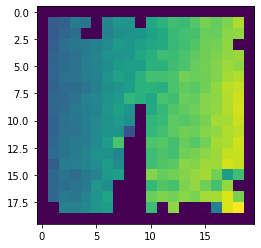

In [132]:
plt.imshow(x)

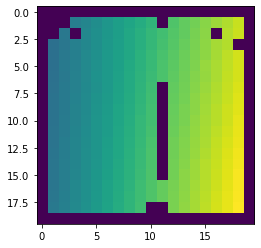

In [120]:
plt.imshow(xy_data[0,:,:,0])

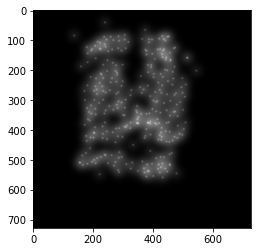

In [133]:
plt.imshow(reconstruct_image(res_decoder[0,:,:,0], res_decoder[0,:,:,1]),cmap='gist_gray')